# compute CDSK indices

# Explicit SOM

In [ ]:
plt.ioff()
from IPython.display import display, clear_output
from simpsom.neighborhoods import Neighborhoods
%matplotlib inline

epochs = 100
start_sigma = 1
start_lr = 0.05
win_size = 7
nbatch = len(X_norm) // 64
lon, lat = da_s_coarse.lon.values, da_s_coarse.lat.values
nei = Neighborhoods(np, 6, 4, "hexagons", PBC=True)
neighborhood_caller = partial(nei.neighborhood_caller, neigh_func="gaussian")
size = nei.width * nei.height
weights = np.random.default_rng().random((size, *X_norm.shape[1:]), dtype=np.float32)
nodes = np.arange(size)
clu = None


def iteration_som(thisX: NDArray, weights: NDArray, nodes: NDArray, nbatch: int, win_size: int, data_range: float) -> NDArray:
    batches = np.array_split(thisX, nbatch)
    pre_numerator = np.zeros(weights.shape, dtype=np.float32)
    numerator = pre_numerator.copy()
    for batch in tqdm(batches):
        distances = pairwise_ssim(batch, weights, win_size, data_range)
        indices = np.argmin(distances, axis=1)
        
        series = indices[:, None] == nodes[None, :]
        pop = np.sum(series, axis=0, dtype=np.float32)
        for i, s in enumerate(series.T):
            pre_numerator[i, :, :] = np.sum(batch[s], axis=0)
        for i in range(pre_numerator.shape[0]):
            numerator[i, :, :] = np.sum(h[i, :, None, None] * pre_numerator, axis=0)
        
        # numerator = np.einsum('ij, jkl -> ikl', h, numerator)
        denominator = (h @ pop)[:, None, None]
        
        new_weights = np.where(denominator != 0, numerator / denominator, weights)
        weights = (1 - learning_rate) * weights + learning_rate * new_weights
        weights = weights.astype(np.float32)
    return weights


def prepare_plot(weights, lon, lat, Xmin, Xmax):
    weights = descale(weights, Xmin, Xmax)
    weights_to_plot = xr.DataArray(weights, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da


def prepare_plot_pca(weights, pca, lon, lat):
    weights_to_plot = pca.inverse_transform(weights).reshape(weights.shape[0], *da_s.shape[1:])
    weights_to_plot = xr.DataArray(weights_to_plot, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da


for epoch in range(epochs):
    sigma = start_sigma * np.exp(-epoch / epochs * 3)
    learning_rate = start_lr * np.exp(-epoch / epochs)
    thisX = X_norm.copy()
    np.random.shuffle(thisX)
    h = neighborhood_caller(nodes, sigma=sigma).astype(np.float32)
    weights = iteration_som(thisX, weights, nodes, nbatch, win_size, data_range)   
    weights_to_plot = prepare_plot(weights, lon, lat, Xmin, Xmax) 
    if clu:
        plt.close(clu.fig)
        del clu
    clear_output(wait = True)
    print(f'ite: {epoch + 1}/{epochs}, lr: {learning_rate:.2e}, sigma: {sigma:.2e}', end='\r')
    clu = Clusterplot(nei.height, nei.width, exp_s.region, honeycomb=True)
    clu.add_contourf(weights_to_plot, q=0.97, transparify=2, cmap=colormaps.matter)  
    display(clu.fig)
if clu:
    plt.close(clu.fig)
    del clu

# Sweep sizes

In [ ]:
from simpsom.neighborhoods import Neighborhoods
def pairwise_distances_wrapper(X, Y=None, **kwargs):
    X = X.reshape(X.shape[0], -1)
    if Y is not None:
        Y = Y.reshape(Y.shape[0], -1)
    return pairwise_distances(X, Y, **kwargs)

metric = "euclidean"
its = np.random.randint(0, exp_s.da.time.shape[0], size=10000)
X = to_zero_one(coarsen_da(exp_s.da.isel(time=its), 1.5).values)[0]
meanX = X.mean(axis=0)[None, ...]
stdX = X.std(axis=0)[None, ...]
X_norm = (X - meanX) / stdX

In [ ]:
all_x = np.arange(4, 11, 2)
all_dx = [0, -2]
bics1 = np.zeros((len(all_x), len(all_dx)))
bics2 = bics1.copy()
maxprojs = bics1.copy()
for i, x in tqdm(enumerate(all_x), total=len(all_x)):
    for j, dx in enumerate(all_dx):
        net, centers, labels = exp_s.som_cluster(
            x,
            x + dx,
            metric=metric,
            return_type=RAW_REALSPACE,
            force=False,
            train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
        )
        weights = np.load(exp_s.path.joinpath(f"som_{x}_{x+dx}_pbc_euclidean.npy"))
        m, sx, sy = weights.shape
        meanW, stdW = weights.mean(axis=0), weights.std(axis=0)
        weights_norm = (weights - meanW) / stdW
        distances = pairwise_distances_wrapper(X_norm, weights_norm, n_jobs=12, metric="sqeuclidean")
        neighborhood = Neighborhoods(x, x + dx, "hexagons", PBC=True)
        h = neighborhood.neighborhood_caller(np.arange(m), 0.05, "gaussian")
        distances_ = h @ distances.T
        labels = np.argmin(distances_, axis=0)
        masks = labels_to_mask(labels)
        n = np.sum(masks, axis=0)
        N = X.shape[0]
        d = sx * sy
        loss = np.sum(np.amin(distances_, axis=0))
        bics1[i, j] = (1.0 / (N - m) / d) * loss + m * d * np.log(N)
        
        cl_var = (1.0 / (N - m) / d) * loss
        const_term = 2 * m * np.log(N) * d
        bics2[i, j] = np.sum(n * np.log(n) - n * np.log(N) - n * d / 2 * np.log(2 * np.pi * cl_var) - (n - 1) * d / 2) - const_term
        
        maxprojs[i, j] = (1.0 / d) * np.amin(np.amax(np.einsum('ikl, jkl -> ij', X_norm, weights_norm), axis=1))

100%|██████████| 4/4 [57:06<00:00, 856.67s/it]


In [ ]:
np.save("/storage/homefs/hb22g102/persistent-extremes-era5/results/bics1.npy", bics1)
np.save("/storage/homefs/hb22g102/persistent-extremes-era5/results/bics2.npy", bics2)
np.save("/storage/homefs/hb22g102/persistent-extremes-era5/results/maxprojs.npy", maxprojs)

In [ ]:
maxprojs = np.load("/storage/homefs/hb22g102/persistent-extremes-era5/results/som_maxprojs.npy")
losses = np.load("/storage/homefs/hb22g102/persistent-extremes-era5/results/som_losses.npy")

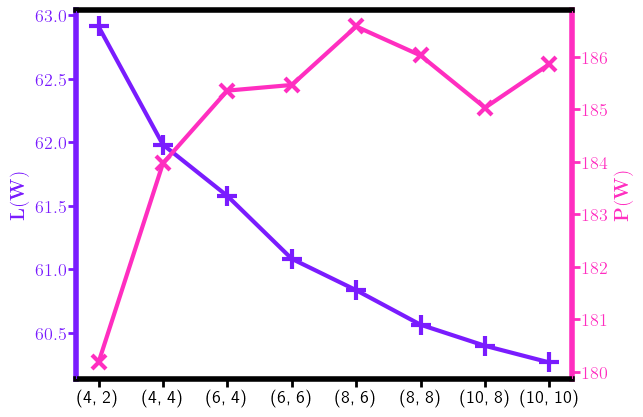

In [ ]:
c1 = COLORS[2]
c2 = COLORS[1]

fig, ax = plt.subplots()
all_x = np.arange(4, 11, 2)
all_dx = [0, -2]
ax.plot(losses[:, [1, 0]].flatten(), color=c2, lw=3, marker="+", ms=15, mew=3)
ax.set_xticks(np.arange(8), [f'({x}, {x+dx})' for x, dx in product(all_x, all_dx[::-1])], fontsize=13)
ax.set_ylabel("$\mathbf{L(W)}$", fontsize=14)
ax.spines['left'].set_color(c2)
ax.spines['right'].set_color(c1)
ax.tick_params(color=c2, labelcolor=c2, axis="y")
ax.yaxis.label.set_color(c2)

axx = ax.twinx()
axx.plot(maxprojs[:, [1, 0]].flatten(), color=c1, lw=3, marker="x", ms=10, mew=3)
axx.spines['right'].set_color(c1)
axx.spines['left'].set_color(c2)
axx.set_ylabel("$\mathbf{P(W)}$", fontsize=14)
axx.yaxis.label.set_color(c1)
axx.tick_params(color=c1, labelcolor=c1, axis="y")

for dire in ['top','bottom','left','right']:
    ax.spines[dire].set_linewidth(4)

ax.tick_params(width=2, length=6, pad=1, labelsize=13)
axx.tick_params(width=2, length=6, pad=1, labelsize=13)
    
plt.savefig(f"{FIGURES}/som_training.png")

In [ ]:
fig, ax = plt.subplots()
all_x = np.arange(4, 11, 2)
all_dx = [0, -2]
ax.plot(losses[:, [1, 0]].flatten(), color="red", lw=2)
ax.set_xticks(np.arange(8), [f'({x}, {x+dx})' for x, dx in product(all_x, all_dx[::-1])])
ax.set_ylabel("SOM Loss")
ax.spines['left'].set_color('red')
ax.spines['right'].set_color('blue')
ax.tick_params(color='red', labelcolor='red', axis="y")
ax.yaxis.label.set_color('red')


axx = ax.twinx()
axx.plot(maxprojs[:, [1, 0]].flatten(), color="blue", lw=2)
axx.spines['right'].set_color('blue')
axx.spines['left'].set_color('red')
axx.set_ylabel("Min Proj")
axx.yaxis.label.set_color('blue')
axx.tick_params(color='blue', labelcolor='blue', axis="y")

plt.savefig(f"{FIGURES}/som_training.png")

In [ ]:
list(ax.spines.keys())

In [ ]:
fig, ax = plt.subplots()
ax.plot(maxprojs[:, [1, 0]].flatten())
ax.set_xticks(np.arange(8), [f'({x}, {x+dx})' for x, dx in product(all_x, all_dx[::-1])])

# test pairwise ssim

In [ ]:
its = np.random.randint(0, exp_s.samples_dims["time"].shape[0], size=20)
da_ = exp_s.da.isel(time=its)

In [ ]:
from simpsom.distances import pairwise_ssim
da_ = exp_s.da.isel(time=its)
da_ = to_zero_one(coarsen_da(da_, 1.5).values)[0]
data_range = da_.max() - da_.min()
results = pairwise_ssim(da_, win_size=3, strides=1, data_range=data_range.item())
results = results[np.triu_indices_from(results, k=1)]
results_2 = pairwise_distances(da_.reshape(da_.shape[0], -1))
results_2 = results_2[np.triu_indices_from(results_2, k=1)] / np.sqrt(np.prod(da_.shape[-2:])) * 2

fig, ax = plt.subplots(figsize=(15, 6))
# ax.plot(np.arange(len(results)), (results - results_2) / results_2, lw=4)
ax.plot(np.arange(len(results)), results, lw=4)
ax.plot(np.arange(len(results_2)), results_2, lw=4)

In [ ]:
np.mean(results / results_2 / 1.044067)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(np.arange(len(results)), results, lw=4)
ax.plot(np.arange(len(results_2)), results_2 * 2, lw=4)

In [ ]:
clu = Clusterplot(1, 2, exp_s.region)
_ = clu.add_contourf(da_)